<a href="https://colab.research.google.com/github/katybohanan/5542-RNN_LSTM_GRU/blob/main/RNN_LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Real-World Data Processing with RNN, LSTM, and GRU in PyTorch
This notebook demonstrates how to use RNN, LSTM, and GRU on real-world time-series data and visualize the training performance.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os
import kagglehub
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import pipeline

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [3]:
# Path to the cached dataset
cache_path = os.path.expanduser("~/.cache/kagglehub/datasets")

data_path = os.path.join(cache_path, "mryanm/luflow-network-intrusion-detection-data-set/versions/240")

if not os.path.exists(data_path):
    # Download latest version
    data_path = kagglehub.dataset_download("mryanm/luflow-network-intrusion-detection-data-set")

# List to store dataframes
df_list = []

# Load and optimize each CSV
for year in sorted(os.listdir(data_path)):  # Sorting for consistency
    year_path = os.path.join(data_path, year)
    if os.path.isdir(year_path) and year_path.endswith("2022"): # only use 2022 for now
        for month in sorted(os.listdir(year_path)):
            month_path = os.path.join(year_path, month)
            if os.path.isdir(month_path):
                for day in sorted(os.listdir(month_path)):
                    day_path = os.path.join(month_path, day)
                    if os.path.isdir(day_path) and day_path.endswith("12"): # only use day 14 for now
                        for file in os.listdir(day_path):
                            if file.endswith(".csv"):
                                full_path = os.path.join(day_path, file)
                                data = pd.read_csv(full_path)

                                # Extract date info safely
                                y, m, d = map(int, file.split(".")[:3])
                                data["Year"] = y
                                data["Month"] = m
                                data["Day"] = d

                                # Reduce memory usage BEFORE adding to list
                                data = reduce_mem_usage(data, verbose=False)
                                df_list.append(data)

# Final concatenation
df = pd.concat(df_list, ignore_index=True)

100%|██████████| 4.59G/4.59G [03:27<00:00, 23.8MB/s]

Extracting files...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26167 entries, 0 to 26166
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   avg_ipt        26167 non-null  float32
 1   bytes_in       26167 non-null  int32  
 2   bytes_out      26167 non-null  int32  
 3   dest_ip        26167 non-null  int16  
 4   dest_port      18719 non-null  float32
 5   entropy        26167 non-null  float16
 6   num_pkts_out   26167 non-null  int16  
 7   num_pkts_in    26167 non-null  int16  
 8   proto          26167 non-null  int8   
 9   src_ip         26167 non-null  int16  
 10  src_port       18719 non-null  float32
 11  time_end       26167 non-null  int64  
 12  time_start     26167 non-null  int64  
 13  total_entropy  26167 non-null  float32
 14  label          26167 non-null  object 
 15  duration       26167 non-null  float16
 16  Year           26167 non-null  int16  
 17  Month          26167 non-null  int8   
 18  Day   

In [5]:
df['label'].value_counts()

,count
label,
outlier,19719
malicious,3748
benign,2700


In [6]:
df['label_encoded'] = df['label'].map({'benign': 0, 'malicious': 1, 'outlier': 2})
df['label_encoded'].value_counts()

,count
label_encoded,
2,19719
1,3748
0,2700


In [7]:
df.isna().sum()

,0
avg_ipt,0
bytes_in,0
bytes_out,0
dest_ip,0
dest_port,7448
entropy,0
num_pkts_out,0
num_pkts_in,0
proto,0
src_ip,0


In [8]:
df.drop(['label', 'dest_port', 'src_port'], axis=1, inplace=True)

In [9]:
class SequenceDataset(Dataset):
    def __init__(self, data, feature_cols, label_col, seq_length):
        self.data = data
        self.feature_cols = feature_cols
        self.label_col = label_col
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length  # Avoid indexing past the end

    def __getitem__(self, idx):
        X_seq = self.data[self.feature_cols].iloc[idx:idx+self.seq_length].values
        y_label = self.data[self.label_col].iloc[idx+self.seq_length]

        # Convert to tensors
        X_seq = torch.tensor(X_seq, dtype=torch.float32)
        y_label = torch.tensor(y_label, dtype=torch.int64)  # Use int64 for classification

        return X_seq, y_label

feature_cols = df.drop(['label_encoded'], axis=1).columns
label_col = 'label_encoded'

# Create dataset
seq_length = 30  # Use past 30 time steps to predict the next one
dataset_size = len(df)

train_size = int(0.8 * dataset_size)  # 80% for training
val_size = dataset_size - train_size  # Remaining 20% for validation

# Split the dataset
train_dataset = SequenceDataset(df[:train_size], feature_cols, label_col, seq_length)
val_dataset = SequenceDataset(df[train_size:], feature_cols, label_col, seq_length)

# Create DataLoaders
batch_size = 128  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


##Define RNN, LSTM, and GRU Models

In [10]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out

##Training the Models and Recording Loss

In [11]:
def train_model(model, train_loader, val_loader, epochs=1, learning_rate=0.0001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()

        for i, (X_batch, y_batch) in enumerate(train_loader):
            optimizer.zero_grad()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)  # Forward pass
            loss = criterion(output, y_batch)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            train_losses.append(loss.item())
            if i % 10 == 0:
                print(f'Batch {i}/{len(train_loader)}, Average Loss: {np.mean(train_losses)}')

        model.eval()
        with torch.no_grad():  # Disable gradient calculations during validation
            for i, (X_batch, y_batch) in enumerate(val_loader):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)  # Forward pass
                loss = criterion(output, y_batch)  # Compute loss
                val_losses.append(loss.item())
            print(f'Validation Loss: {np.mean(val_losses)}')

    return train_losses, val_losses

# Initialize models
rnn_model = RNNModel(len(feature_cols), 64, 3)
lstm_model = LSTMModel(len(feature_cols), 64, 3)
gru_model = GRUModel(len(feature_cols), 64, 3)

# Train models and record loss
rnn_losses = train_model(rnn_model, train_loader, val_loader)

Batch 0/164, Average Loss: 1.3132855892181396
Batch 10/164, Average Loss: 1.293408675627275
Batch 20/164, Average Loss: 1.265710325468154
Batch 30/164, Average Loss: 1.237782862878615
Batch 40/164, Average Loss: 1.2107725666790474
Batch 50/164, Average Loss: 1.1870473109039605
Batch 60/164, Average Loss: 1.1625770467226622
Batch 70/164, Average Loss: 1.1419181983235855
Batch 80/164, Average Loss: 1.1205939289964275
Batch 90/164, Average Loss: 1.0997071462673145
Batch 100/164, Average Loss: 1.0784671973473956
Batch 110/164, Average Loss: 1.0584943858352867
Batch 120/164, Average Loss: 1.0408658730097053
Batch 130/164, Average Loss: 1.0258547722838307
Batch 140/164, Average Loss: 1.0095111664305343
Batch 150/164, Average Loss: 0.9964319053075171
Batch 160/164, Average Loss: 0.981084790659247
Validation Loss: 0.757599784106743


In [12]:
lstm_losses = train_model(lstm_model, train_loader, val_loader)
gru_losses = train_model(gru_model, train_loader, val_loader)

Batch 0/164, Average Loss: 1.1929457187652588
Batch 10/164, Average Loss: 1.1896937543695623
Batch 20/164, Average Loss: 1.1818049919037592
Batch 30/164, Average Loss: 1.1711023853671165
Batch 40/164, Average Loss: 1.16118348517069
Batch 50/164, Average Loss: 1.1528223215364943
Batch 60/164, Average Loss: 1.1430408231547622
Batch 70/164, Average Loss: 1.1358590243567883
Batch 80/164, Average Loss: 1.1290604420650152
Batch 90/164, Average Loss: 1.1214439882026923
Batch 100/164, Average Loss: 1.113232460352454
Batch 110/164, Average Loss: 1.1047857785010122
Batch 120/164, Average Loss: 1.0964947401984664
Batch 130/164, Average Loss: 1.089926629121067
Batch 140/164, Average Loss: 1.0821060047927478
Batch 150/164, Average Loss: 1.0752760361361977
Batch 160/164, Average Loss: 1.0667778901431872
Validation Loss: 0.9374962492686946
Batch 0/164, Average Loss: 1.027820348739624
Batch 10/164, Average Loss: 0.9942971847274087
Batch 20/164, Average Loss: 0.9776855593635922
Batch 30/164, Average Lo

##Visualizing the Training Loss

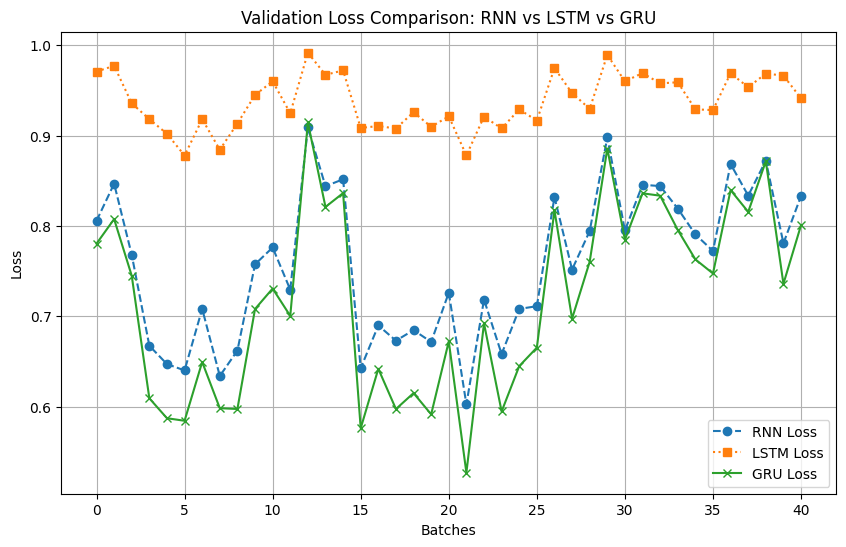

In [13]:
# Plot Training Loss Curves
plt.figure(figsize=(10,6))
plt.plot(rnn_losses[1], label='RNN Loss', linestyle='dashed', marker='o')
plt.plot(lstm_losses[1], label='LSTM Loss', linestyle='dotted', marker='s')
plt.plot(gru_losses[1], label='GRU Loss', linestyle='solid', marker='x')

plt.xlabel('Batches')
plt.ylabel('Loss')
plt.title('Validation Loss Comparison: RNN vs LSTM vs GRU')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen2.5-3B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

prompt = f"""Given that I have sequential data with the following columns: {df.columns}, Explain why the RNN performs better than the GRU model,
              which performs better than the LSTM. This data is flow-based network data meant to be used for classification of benign or malicious flows.
              Here are the model architectures, for extra context:
              class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out"""
messages = [
    {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=512
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.6k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [15]:
print(response)

The performance difference between an RNN (Recurrent Neural Network), LSTM (Long Short-Term Memory), and GRU (Gated Recurrent Unit) can be attributed to several factors related to their architecture and how they handle sequential data:

### Recurrent Neural Networks (RNN)
- **Basic Structure**: RNNs are designed to handle sequential data by maintaining a hidden state across time steps. Each time step's output is a function of the current input and the previous hidden state.
- **Limitation**: One of the main limitations of vanilla RNNs is the vanishing gradient problem, where gradients can decay too slowly or too quickly, making it difficult to learn long-term dependencies.

### Long Short-Term Memory (LSTM)
- **Architecture**: LSTMs solve the vanishing gradient problem by introducing memory cells and gates that control the flow of information through the network. The cell state allows the network to remember information over long sequences.
- **Structure**: LSTMs have three gates (inpu

##Summary and Insights
* The loss curves indicate how well each model trains over time.
* LSTM and GRU generally perform better than RNN on time-series data.
* LSTM retains long-term memory well, making it good for stock price prediction.
* GRU is faster than LSTM and performs similarly.
* RNN struggles with long-term dependencies due to vanishing gradients.
* The predictions indicate how each model forecasts stock prices based on historical data.